In [341]:
import pkg_resources

from matplotlib import pyplot as plt
import numpy as np

from multiearth_challenge.datasets import segmentation_dataset as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ImageSegmentationDataset Class Usage

This notebook contains examples for how the [ImageSegmentationDataset](https://github.com/MIT-AI-Accelerator/multiearth-challenge/blob/c2318665ab94451eea4bd1b9e31a71655c6be001/src/multiearth_challenge/datasets/segmentation_dataset.py#L9) class can be used to sample data from the NetCDF files provided as part of the MultiEarth challenge.

In [342]:
import pkg_resources

from matplotlib import pyplot as plt
import numpy as np

from multiearth_challenge.datasets import segmentation_dataset as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Specifying Dataset Data
In this example, Sentinel-2 visible imagery will serve as the source imagery and deforestation segmentation masks will serve as the target imagery.

In [343]:
# Set data paths to sample data included as part of the MultiEarth repository
source_files = [pkg_resources.resource_filename("multiearth_challenge", "data/sample_dataset/landsat8_sample.nc"),]
segmentation_files = [pkg_resources.resource_filename("multiearth_challenge", "data/sample_dataset/deforestation_sample.nc")]

Specify the bands to include for the source data. This is set with a dictionary whose keys are the sensor and the values are a list of bands.</br>
Acceptable sensor and band values are:</br>
"Landsat-5": ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'ST_B6', 'SR_B7', 'QA_PIXEL']</br>
"Landsat-8": ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL']</br>
"Sentinel-1": ['VV', 'VH']</br>
"Sentinel-2": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'QA60']</br>
"Fire": ['BurnDate', 'ConfidenceLevel', 'LandCover', 'ObservedFlag']</br>
"Deforestation": None, There is only a single unnamed band associated with the deforestation data so there are no bands to select</br>

The bands for the segmentation data are automatically selected for the two provided datasets. For deforestation data the one segmentation mask is selected. For fire data the "ConfidenceLevel" band is selected.

In [344]:
source_bands = {"Landsat-8": ['ST_B10', 'SR_B7', 'SR_B6', 'SR_B5', 'SR_B4', 'SR_B3', 'SR_B2', 'SR_B1', 'QA_PIXEL']} 
# RGB visible bands

### Creating the Dataset
Set additional parameters used by the ImageSegmentationDataset

In [345]:
# If True, returned source images will have multiple channels in increasing order of frequency (e.g., red, green, blue for visible), co-pol before cross-pol, and with bands not originating from collected imagery coming last and in alphabetical order. 
# The metadata returned with the imagery will also specify the channel order. If False, each band is treated as a separate sample.
merge_source_bands = False # bool

# The minimum and maximum allowable cloud coverage allowed in visible and IR imagery as a fraction [0, 1]. 
# Setting the maximum above 0 may be useful when incorporating SAR imagery into a multimodal model where a large fraction of cloud coverage may be acceptable. 
# Similarly, evaluation in challenging cases with a minimum on the amount of cloud coverage may be desired.
# Note, there may be some innacuracies in the identified cloud coverage provided by the sensor's QA bands. This is especially true for Sentinel-2 data.
source_cloud_coverage = (0.0, 0.0) # Tuple[float, float]

# The minimum and maximum inclusive relative time window in days around the segmentation image from which source imagery is pulled. 
# If the minimum is None, there is no filter on the minimum relative date. Similarly, no maximum can be specified with a value of None.
# For example, with a value of (-7, 7) only source imagery within the interval of -7 days before and 7 days after a segmentation image date will be returned as source imagery. 
source_date_window = (-7, 7) # Tuple[Optional[float], Optional[float]]

# If True, for each target image only a single source image is returned in a unique pair. A single source image may be paired with multiple target images and vice-versa depending on data filters applied. 
# If False, each target image is returned with all source images at the same location that satisfy applied data filters. This may be useful if you want to include information from multiple images when making a single segmentation prediction.
single_source_image = True

# If True, if no source or target image remain after data filtering, raise a ValueError, otherwise this dataset will have length 0. 
error_on_empty = True # bool

Create the dataset. The sample data is small, but depending on the number of images contained in the NetCDF files, calculating the cloud coverage statistics may take several minutes.

In [346]:
dataset = sd.ImageSegmentationDataset(
    source_files,
    segmentation_files,
    source_bands,
    merge_source_bands,
    source_cloud_coverage,
    source_date_window,
    single_source_image,
    error_on_empty,
)   

### Data Returned by the Dataset
The dataset serves as a sequence of samples. Each call to \_\_getitem__ will return a two element tuple where the second element holds a dictionary with a single target image and associated metadata. The first element holds a list of dictionaries where each one holds a source image along with associated metadata at the same location that satisfies the source_date_window. If single_source_image is True, this will always be a one element list with the multiple possible pairings being returned as separate samples.

Note, for this example the returned source data is cloud free and within +- 10 days of the target deforestation segmentation image date. Cloud coverage is determined by information in the sensor's QA band, which may have inaccuracies.

In [347]:
print(f"Number of dataset samples: {len(dataset)}")

# Get sample with index 0
source_data, target_data = dataset[0]

# The returned source_data is a list of all data related to a target image. 
# During initialization since single_source_image was set to True, this list will always have one element.
print(f"Source data key values returned: {source_data[0].keys()}")
print(f"Target data key values returned: {target_data.keys()}")

Number of dataset samples: 27
Source data key values returned: dict_keys(['image', 'data_source', 'bands', 'lat_lon', 'date'])
Target data key values returned: dict_keys(['image', 'data_source', 'bands', 'lat_lon', 'date'])


### Single channel vs. Multi-channel Imagery
The returned source images in the dataset above are single band and there are separate paired samples for each band. Below is an example where the bands have been merged into a 3-channel RGB image.

In [348]:
# Make a second dataset with merged bands
merge_source_bands = True
dataset_merged_bands = sd.ImageSegmentationDataset(
    source_files,
    segmentation_files,
    source_bands,
    merge_source_bands,
    source_cloud_coverage,
    source_date_window,
    single_source_image,
    error_on_empty,
)
                  
# 1/3 target samples have been merged resulting in 1/3 of the number of samples compared to separate bands.
print(f"Number of merged band dataset samples: {len(dataset_merged_bands)}")
# Get sample with index 0
source_data_merged_bands, target_data_merged_bands = dataset_merged_bands[0]
print(f"Shape of the source image without merging bands: {source_data[0]['image'].shape}")
print(f"List of bands associated with the single band source image: {source_data[0]['bands']}")
print(f"Shape of the source image with merged bands: {source_data_merged_bands[0]['image'].shape}")
print(f"List of bands associated with the multi-band source image: {source_data_merged_bands[0]['bands']}") # This list corresponds to the channels in the image with the first band corresponding to channel index 0, the second channel index 1, etc.

Number of merged band dataset samples: 3
Shape of the source image without merging bands: (1, 85, 85)
List of bands associated with the single band source image: ['QA_PIXEL']
Shape of the source image with merged bands: (9, 85, 85)
List of bands associated with the multi-band source image: ['ST_B10', 'SR_B7', 'SR_B6', 'SR_B5', 'SR_B4', 'SR_B3', 'SR_B2', 'SR_B1', 'QA_PIXEL']


### Image Characteristics
The collected images may require normalization for visualization. Here we perform a simple normalization without color balancing.</br>
Also, it should be noted that the filtering of cloudy images uses the Sentinel-2 QA band which may have inaccuracies resulting in some images with high pixel value cloud coverage obscuring land. Additional filtering or masking of cloud coverage can be applied if needed.

In [349]:
def normalize(img):
    img = img.astype(np.float64)
    img -= np.min(img)
    img /= np.max(img)
    return img

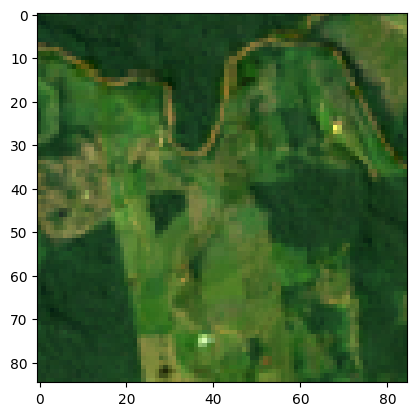

In [350]:
image = source_data_merged_bands[0]["image"]

#selecionado as bandas do rgb
rgb_ind = [4,5,6]
rgb = image[rgb_ind, :, :]  # shape (3, H, W)

#selecionando a banda b4
unique_band = [4]
green_img = image[unique_band, :, :]

rgb_norm = normalize(rgb).transpose((1, 2, 0))
green_norm = normalize(green_img).transpose((1, 2, 0))

plt.imshow(rgb_norm)


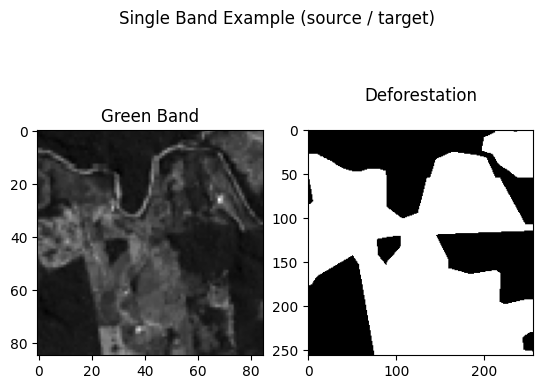

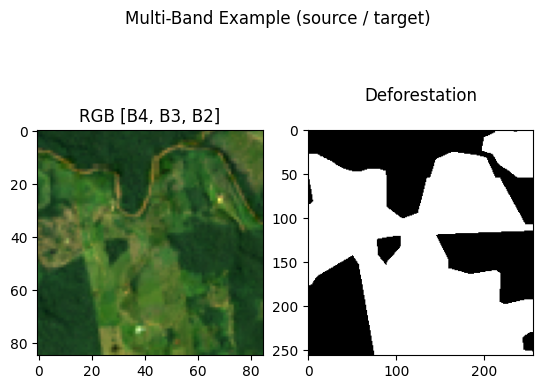

In [351]:
fig1, axs1 = plt.subplots(1, 2)
fig1.suptitle("Single Band Example (source / target)")
axs1[0].set_title("Green Band")
_ = axs1[0].imshow(green_norm, cmap='gray')
axs1[1].set_title(f"{target_data['data_source']}\n")
_ = axs1[1].imshow(target_data["image"].squeeze(), cmap="gray")

fig2, axs2 = plt.subplots(1, 2)
fig2.suptitle("Multi-Band Example (source / target)")
axs2[0].set_title("RGB [B4, B3, B2]")
_ = axs2[0].imshow(rgb_norm)
axs2[1].set_title(f"{target_data_merged_bands['data_source']}\n")
_ = axs2[1].imshow(target_data_merged_bands["image"].squeeze(), cmap="gray")

In [352]:
#funcao de normalização da matriz img que contem valores entre [0., 1.[ passando para valores entre[0,255]
def normalizacao(img):
    
    img = (img - img.min())/(img.max() - img.min())
    img *= 255 
    
    return img.astype(np.uint8)

##funcao de amostragem, onde dado uma matriz, seu tamanho e e tamanho lateral da nova imagem
##consegue digitalizar as coordenadas da "imagem real" a partir do uso de slicing(cortando) 
def amostragem(grid, c, n,):
    if n > c:
        print("Erro")
        return None
    #realiza o calculo de quantas regioes a img digital tera aka nova dimensao
    regioes = c//n

    ##nova imagem 
    new_grid  = grid[::regioes, ::regioes]
    
    return new_grid

#Funcao de Quantizacao
#dado uma imagem e o numero de bits(b) realiza a discretizacao da imagem 
def quantizacao(img, b):
    ##normalizando a matriz + conversao de float para inteiro sem sinal
    img = normalizacao(img)

    if b <= 0:
        print("Erro")
        return None
    #deixa apenas os B bits mais significativos e zera os outros
    img = img >> 8 - b
    img = img << 8 - b

    return img

def luminance(image):
    l = 0.2126 * image[:, :, 0] + 0.7152 * image[:, :, 1] + 0.0722 * image[:, :, 2]
    return l.astype(np.uint8)


In [353]:
def plot_2img(tg,img1,title1, img2, title2):
    plt.figure(figsize=(10,5))
    plt.suptitle(tg)

    # 1. Imagem original
    plt.subplot(1, 2, 1)
    plt.title(title1)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')

    # 2. Imagem binarizada
    plt.subplot(1,2,2)
    plt.title(title2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
        
def plot_3img(tg, img1, t1, img2, t2, img3, t3):

    # Mostra lado a lado
    plt.figure(figsize=(15, 5))
    plt.suptitle(tg)

    plt.subplot(1, 3, 1)
    plt.title(t1)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(t2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(t3)
    plt.imshow(img3, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    

def plot_imagens(imagens, titulos=None, titulo_geral=None, cmap='gray'):
    
    if titulos is None:
        titulos = [''] * 4  # títulos vazios por padrão

    plt.figure(figsize=(20, 5))

    if titulo_geral:
        plt.suptitle(titulo_geral, fontsize=16, y=1.05)

    tam = len(imagens)
    for i in range(tam):
        plt.subplot(1, tam, i + 1)
        plt.imshow(imagens[i], cmap=cmap)
        plt.title(titulos[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [354]:

##FUNCÕES DE REALCE 
#Histograma
#Computa a distribuição de intensidades de pixel em uma img
def histograma(img, tam):
    acumulador = np.zeros((tam,))
    print(img.shape)
    h, w = img.shape
    for i in range(h):
        for j in range(w):
            acumulador[img[i, j]] += 1
    return acumulador

#Histograma Cumulativo
#Computa a proporcao de intensidades
def histo_cumulativo(h, L):
    acumulador = np.zeros((L,))
    acumulador[0] = h[0]
    for i in range(1, L):
        acumulador[i] = acumulador[i - 1] + h[i]
    return acumulador

#Funcao que aplica uma equalizacao no histograma
#T(z) = ((L-1)/ total_pixels) * Hc(z)
def transf(hc, img, total=None):
    
    h, w = img.shape
    L = 256  # níveis de cinza
    if total is None:
        total = float(h * w)
    new_img = np.zeros_like(img, dtype=np.uint8)
    aux = (L-1)/total
    for i in range(h):
        for j in range(w):
            z = img[i, j]
            new_val = aux * hc[z]
            new_img[i, j] = new_val
    
    return new_img.astype(np.uint8)

#Realiza a equalizacao de forma individual
def equaliza_indiv(imagens):
    img_eq =  []
    for img in imagens:
        h = histograma(img, 256)
        hc = histo_cumulativo(h, 256)
        img_eq.append(transf(hc, img))
        
    return img_eq

#realiza a equalizacao de forma conjunta, i.e, para n imagens
def equaliza_conj(imagens):
    h_conjunto = np.zeros(256)
    for img in imagens:
        h_conjunto += histograma(img, 256)
    
    hc_conjunto = histo_cumulativo(h_conjunto, 256)
    total_pixels = sum(img.size for img in imagens)  # total de pixels do conjunto
    imagens_eq = [transf(hc_conjunto, img, total=total_pixels) for img in imagens]
    
    return imagens_eq, hc_conjunto

#Define a equação do realce gama
def realce_gama(img, gama):
    img_norm  = normalizacao(img.astype(float))
    img_gama = img_norm**(1/gama)
    img_gama = normalizacao(img_gama).astype(np.uint8)
    return img_gama
#Aplica a correção gama na imagem
def correc_gamma(imagem, gama):
    imagens_gama = realce_gama(imagem, gama)
    return imagens_gama
 
def median_filter(image, k):
    new_img = np.zeros_like(image)
    h, w = image.shape

    a = b = k // 2

    img_pad = np.pad(image, a, mode='reflect')

    for i in range(0, h):
        for j in range(0, w):
            neighbourhood = img_pad[i:i + 2 * a + 1, j:j + 2 * b + 1]
            new_img[i, j] = np.median(neighbourhood)

    return new_img

In [355]:
def plot_histograms(images, titles, main_title):
    plt.figure(figsize=(15, 10))
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(2, len(images), i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
        
        plt.subplot(2, len(images), i+1+len(images))
        hist = histograma(img, 256)
        plt.bar(range(256), hist)
        plt.title(f'Histograma {title}')
    
    plt.suptitle(main_title)
    plt.tight_layout()
    plt.show()

In [356]:
def sobel_j_kernel():
    return np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]])


def sobel_i_kernel():
    return np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]])

def conv(i, j, img, kernel):

    h, w = kernel.shape
    a = (h - 1) // 2
    b = (w - 1) // 2
    neighbourhood = img[i - a:i + a + 1, j - b:j + b + 1]

    c_mul = kernel * neighbourhood
    return c_mul.sum()


def convolve(img, kernel):

    new_img = np.zeros_like(img)
    h, w = img.shape

    a = kernel.shape[0] // 2
    b = kernel.shape[1] // 2

    flip_kernel = np.flip(np.flip(kernel, 0), 1)
    img_pad = np.pad(img, a, mode='reflect')

    for i in range(0, h):
        for j in range(0, w):
            new_img[i, j] = conv(i + a, j + b, img_pad, flip_kernel)

    return new_img


(85, 85)


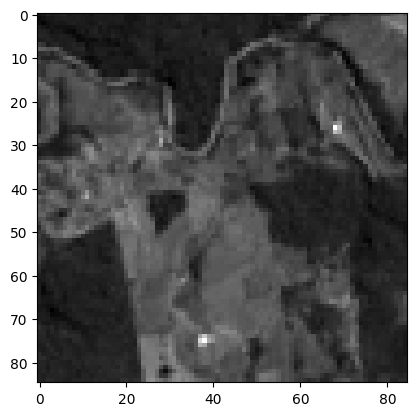

In [357]:
img_g = luminance(normalizacao(rgb_norm))
img_g = normalizacao(img_g)
print(img_g.shape)
plt.imshow(img_g, cmap='gray')

Aplicando o filtro de Minimos QUadrados Restritivos


In [358]:
#Filtro de ruído 
def gaussian_filter(k=3, sigma=1.0):
    arx = np.arange((-k//2) + 1.0, (k//2) + 1.0)
    x,y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))

    return np.array(filt/np.sum(filt))

#Filtro Laplaciano
def operador_laplaciano():
    return np.array([[0,-1,  0],
                     [-1, 4, -1],
                     [0, -1, 0]])

def pad_to_shape(arr, shape):
    """Faz padding de arr para o shape fornecido (centrado)"""
    pad_y = shape[0] - arr.shape[0]
    pad_x = shape[1] - arr.shape[1]
    pad_top = pad_y // 2
    pad_bottom = pad_y - pad_top
    pad_left = pad_x // 2
    pad_right = pad_x - pad_left
    return np.pad(arr, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')

#Filtro de Minimos Quadrados Restritos
def filter_min_quad_rest(sigma, tam_f, img_deg, gama):
    #criando os filtros de degradação(gaussiano) e limitante(laplace)
    laplace = operador_laplaciano()
    filt_deg = gaussian_filter(k = tam_f, sigma=sigma) 
    
    #realizando o padding nos filtros
    filt_h_pad = pad_to_shape(filt_deg, img_deg.shape)
    laplace_pad = pad_to_shape(laplace, img_deg.shape)

    
    #aplicando a tf na imagem e filtros
    img_deg_ft = np.fft.fft2(img_deg)
    filt_h = np.fft.fft2(filt_h_pad)
    filt_h_conj = np.conjugate(filt_h)
    op_laplace = np.fft.fft2(laplace_pad)

    #realizando a filtragem do dominio da frequencia ( produto na frequencia)
    result = (filt_h_conj / (np.abs(filt_h) ** 2 + gama *( np.abs(op_laplace) ** 2))) * img_deg_ft

    #aplicando a tf inversa e voltando pro dominio real
    img_result = np.fft.ifft2(result)
    img_result = np.fft.ifftshift(img_result)
    img_result = np.real(img_result)

    return img_result


In [359]:
gama = 2.0
tam_f = 5
sigm = 0.05
img_filt = filter_min_quad_rest(sigm, tam_f, img_g, gama)

In [360]:
img_eq = equaliza_indiv([img_g])


(85, 85)


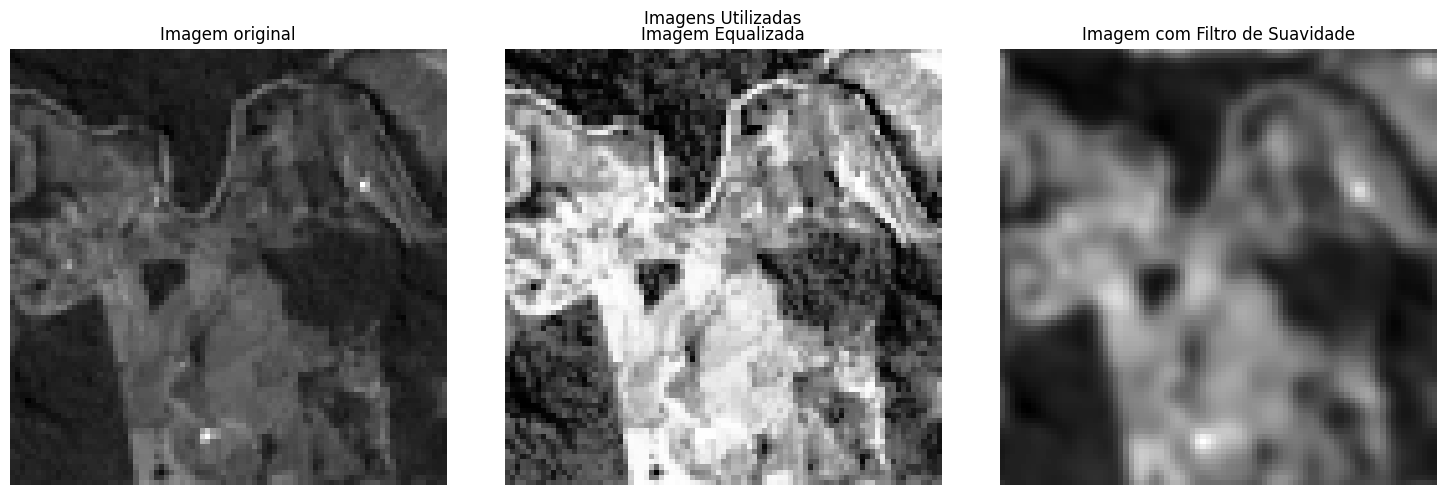

In [361]:
plot_3img("Imagens Utilizadas", img_g, "Imagem original", img_eq[0], "Imagem Equalizada", img_filt, "Imagem com Filtro de Suavidade")

In [362]:
import cv2

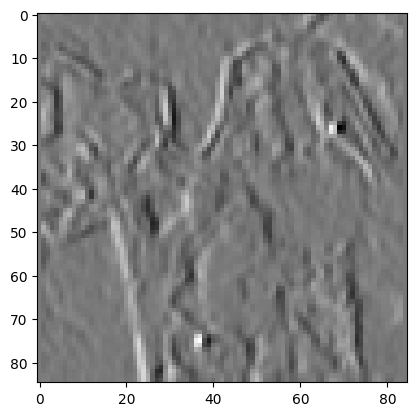

In [363]:
sobelx = cv2.Sobel(img_g, cv2.CV_64F, 1, 0, ksize=3)
plt.imshow(sobelx, cmap='gray')

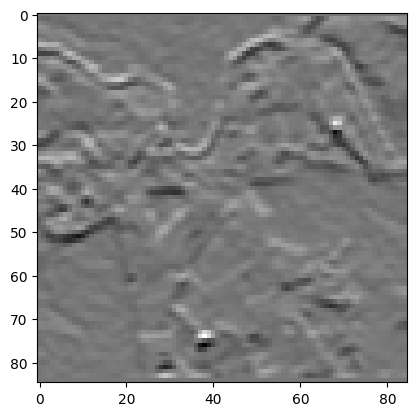

In [364]:
sobely = cv2.Sobel(img_g, cv2.CV_64F, 0, 1, ksize=3)
plt.imshow(sobely, cmap='gray')

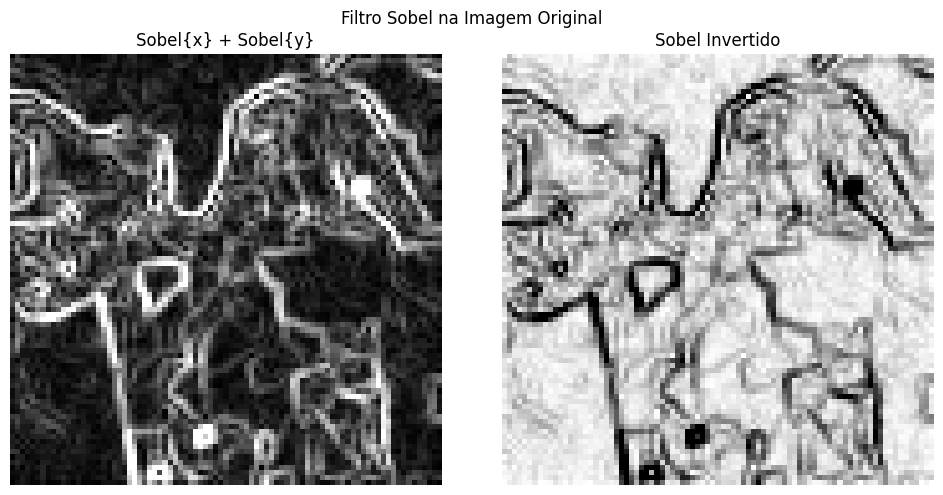

In [365]:
sobel_combined = cv2.magnitude(sobelx, sobely)
sobel_combined = cv2.convertScaleAbs(sobel_combined)
plot_2img("Filtro Sobel na Imagem Original", sobel_combined, "Sobel{x} + Sobel{y}", 255-sobel_combined, "Sobel Invertido")

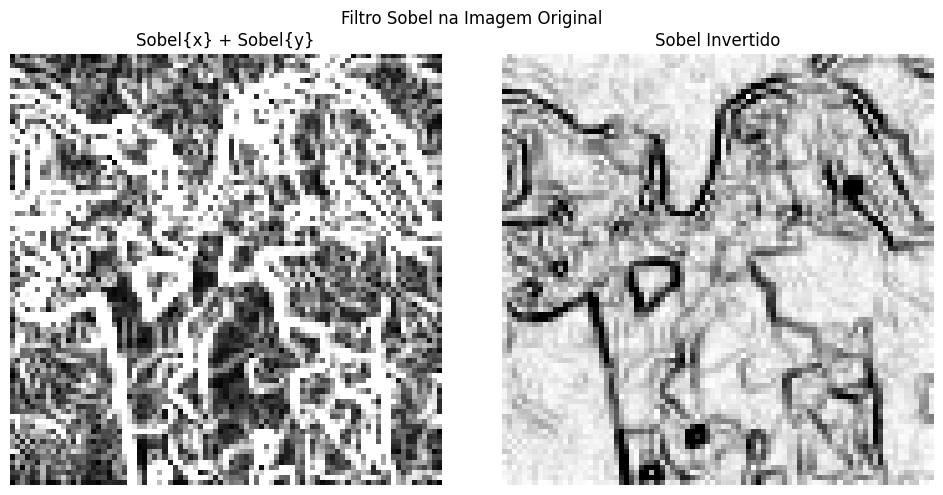

In [366]:
eq_sobelx = cv2.Sobel(img_eq[0], cv2.CV_64F, 1, 0, ksize=3)
eq_sobely = cv2.Sobel(img_eq[0], cv2.CV_64F, 0, 1, ksize=3)
eq_sobel_combined = cv2.magnitude(eq_sobelx, eq_sobely)
eq_sobel_combined = cv2.convertScaleAbs(eq_sobel_combined)
plot_2img("Filtro Sobel na Imagem Original", eq_sobel_combined, "Sobel{x} + Sobel{y}", 255-sobel_combined, "Sobel Invertido")

In [367]:
def metodo_otsu(imagem):
    #calculando o histograma da imagem
    histo, bin_edges = np.histogram(imagem, bins=np.arange(257))

    #calculando o tamanho da imagem
    total_pixels = imagem.size
    current_max, limiar = 0,0

    #calculando a media global da imagem
    media_global = np.sum(histo * np.arange(256))/total_pixels

    #variaveis auxiliares
    peso_fundo, media_fundo = 0, 0
    soma_fundo = 0

    for i in range(256):
        #peso de fundo
        peso_fundo += histo[i]

        if peso_fundo == 0:
            continue

        #veirificando o primeiro plano
        peso_plan1 =  total_pixels - peso_fundo

        if peso_plan1 == 0:
            break

        #media do fundo
        soma_fundo += i * histo[i]
        media_fundo = soma_fundo / peso_fundo

        #media primeiro plano
        media_plan1 =(media_global * total_pixels - soma_fundo)/peso_plan1

        #calculando a variancia intra_classe
        var_interclas = peso_fundo * peso_plan1 * (media_fundo - media_plan1) ** 2

        #maxima var e limiarização
        if var_interclas > current_max:
            current_max = var_interclas
            limiar = i
        
    return limiar
    

##### Imagem Original com Correção Gama

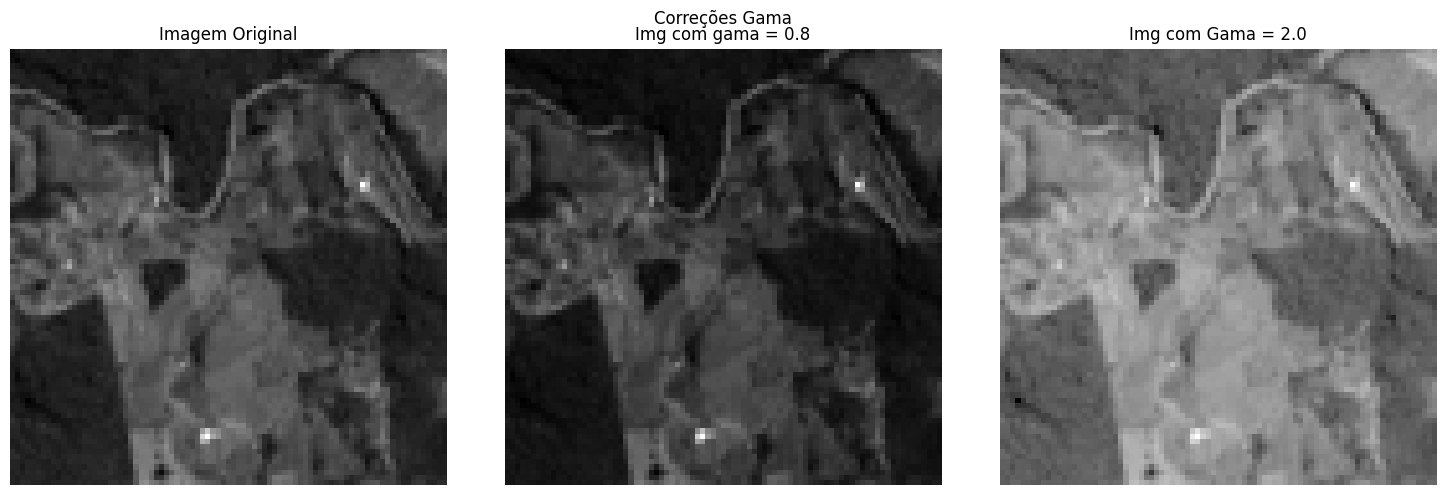

In [368]:
gama1 =0.8
gama2=2.0
img_gama1 = correc_gamma(img_g, gama1)
img_gama2 = correc_gamma(img_g, gama2)


plot_3img("Correções Gama", img_g, "Imagem Original", 
                            img_gama1, f"Img com gama = {gama1}",
                            img_gama2, f"Img com Gama = {gama2}")

(85, 85)
(85, 85)
(85, 85)


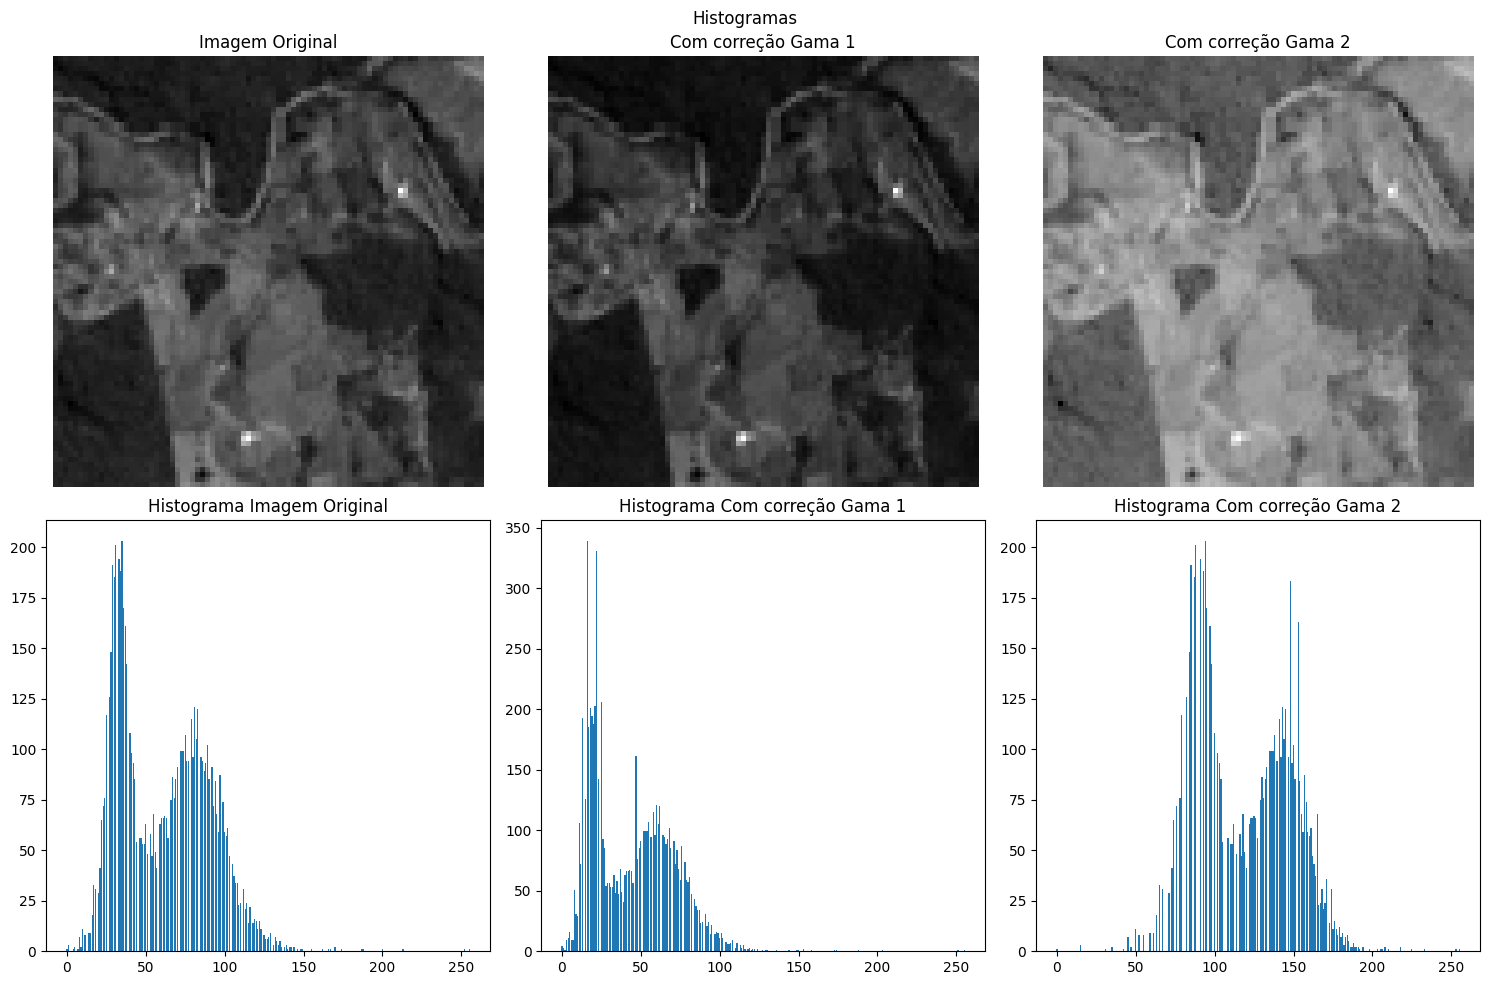

In [369]:
imgs = [img_g, img_gama1,img_gama2]
titles = ['Imagem Original', "Com correção Gama 1", 'Com correção Gama 2']
plot_histograms(imgs, titles, "Histogramas")

##### Imagem Equalizada com Correção Gama

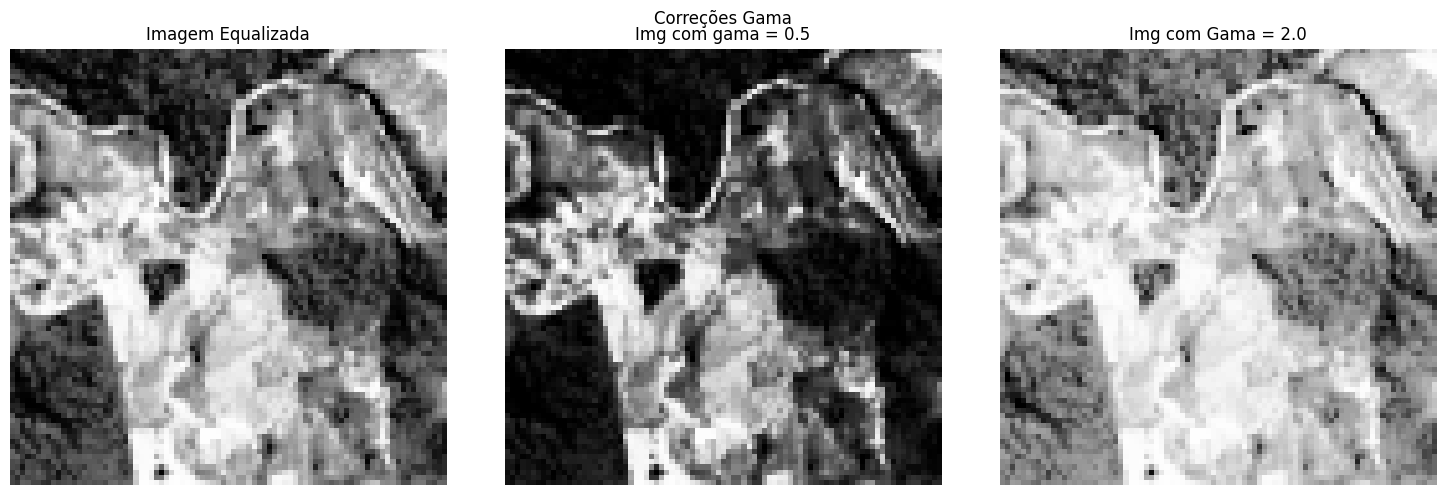

In [370]:
gama1 =0.5
gama2=2.0
img_eq_gama1 = correc_gamma(img_eq[0], gama1)
img_eq_gama2 = correc_gamma(img_eq[0], gama2)

plot_3img("Correções Gama", img_eq[0], "Imagem Equalizada", 
                            img_eq_gama1, f"Img com gama = {gama1}",
                            img_eq_gama2, f"Img com Gama = {gama2}")

(85, 85)
(85, 85)
(85, 85)


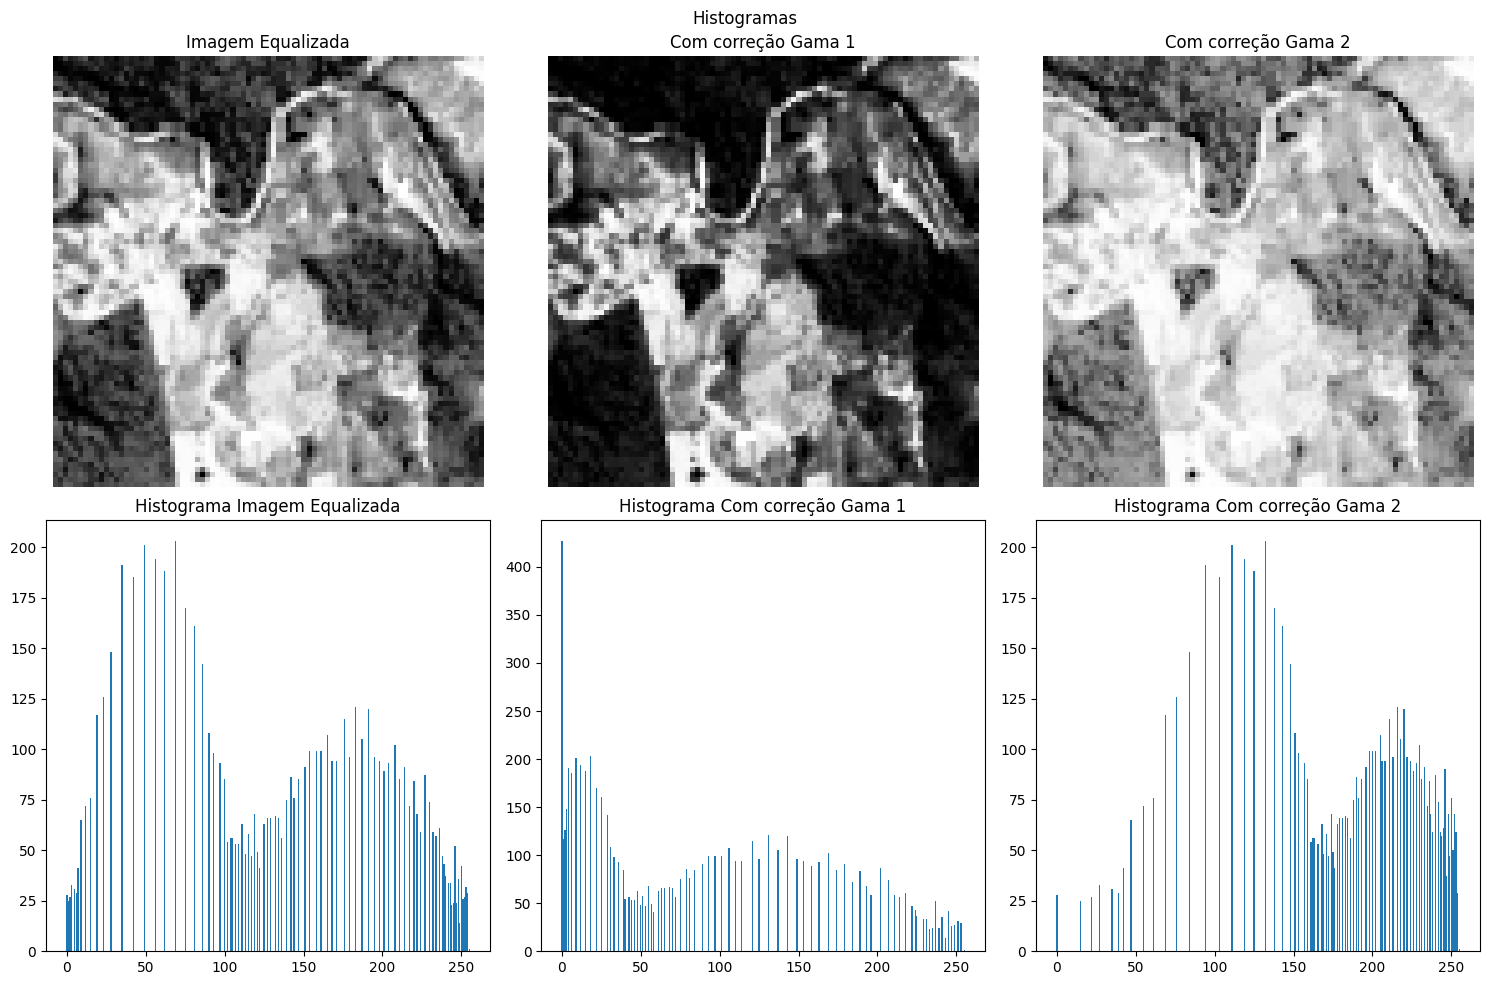

In [371]:
imgs = [img_eq[0], img_eq_gama1,img_eq_gama2]
titles = ['Imagem Equalizada', "Com correção Gama 1", 'Com correção Gama 2']
plot_histograms(imgs, titles, "Histogramas")

##### Aplicação do Otsu em Imagen orginals com correções gama

In [372]:
#Aplicando o Otsu em na imagem original e com correções gama
thresh_original = metodo_otsu(img_g)
img_bin1 =  (img_g > thresh_original).astype(np.uint8) * 255
print(f"Otsu's optimal threshold: {thresh_original}") 

thresh_gama1 = metodo_otsu(img_gama1)
img_bin2 =  (img_gama1 > thresh_gama1).astype(np.uint8) * 255
print(f"Otsu's optimal threshold: {thresh_gama1}") 

thresh_gama2 = metodo_otsu(img_gama2)
img_bin3 =  (img_gama2 > thresh_gama2).astype(np.uint8) * 255
print(f"Otsu's optimal threshold: {thresh_gama2}") 



Otsu's optimal threshold: 61
Otsu's optimal threshold: 45
Otsu's optimal threshold: 119


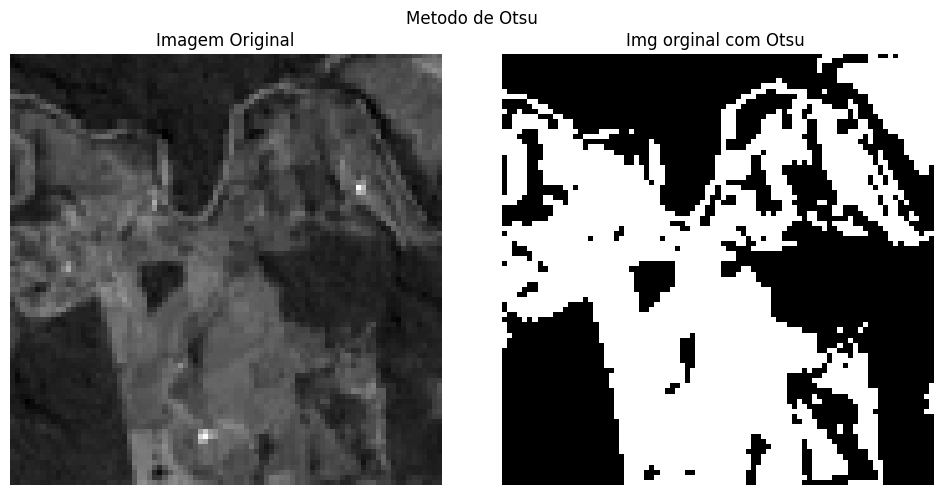

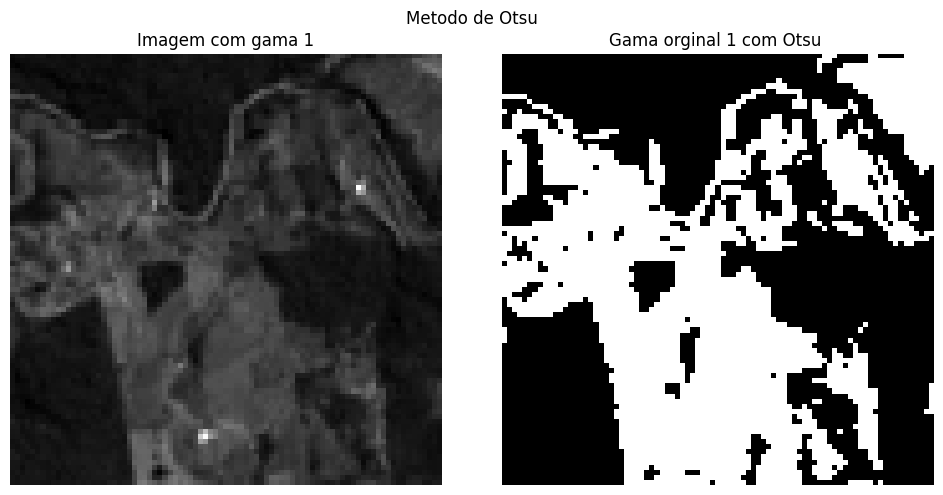

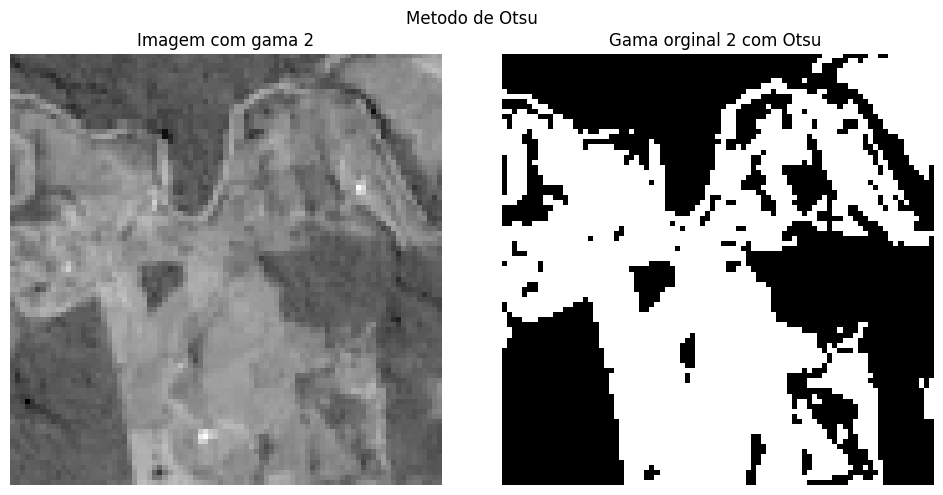

In [373]:
plot_2img("Metodo de Otsu", img_g, "Imagem Original", img_bin1, "Img orginal com Otsu ")
plot_2img("Metodo de Otsu", img_gama1, "Imagem com gama 1", img_bin2, "Gama orginal 1 com Otsu ")
plot_2img("Metodo de Otsu", img_gama2, "Imagem com gama 2", img_bin3, "Gama orginal 2 com Otsu ")

##### Aplicando Otsu em imagens equalizadas com correções gama


In [374]:
#Aplicando Otsu em imagens equalizadas com correções gama
thresh_eq = metodo_otsu(img_eq[0])
img_bin4 =  (img_eq[0] > thresh_eq).astype(np.uint8) * 255
print(f"Otsu's optimal threshold: {thresh_eq}") 

thresh_gama1 = metodo_otsu(img_eq[0])
img_bin5 =  (img_eq_gama1 > thresh_gama1).astype(np.uint8) * 255
print(f"Otsu's optimal threshold: {thresh_gama1}") 

thresh_gama2 = metodo_otsu(img_eq_gama2)
img_bin6 =  (img_eq_gama2 > thresh_gama2).astype(np.uint8) * 255
print(f"Otsu's optimal threshold: {thresh_gama2}") 



Otsu's optimal threshold: 129
Otsu's optimal threshold: 129
Otsu's optimal threshold: 159


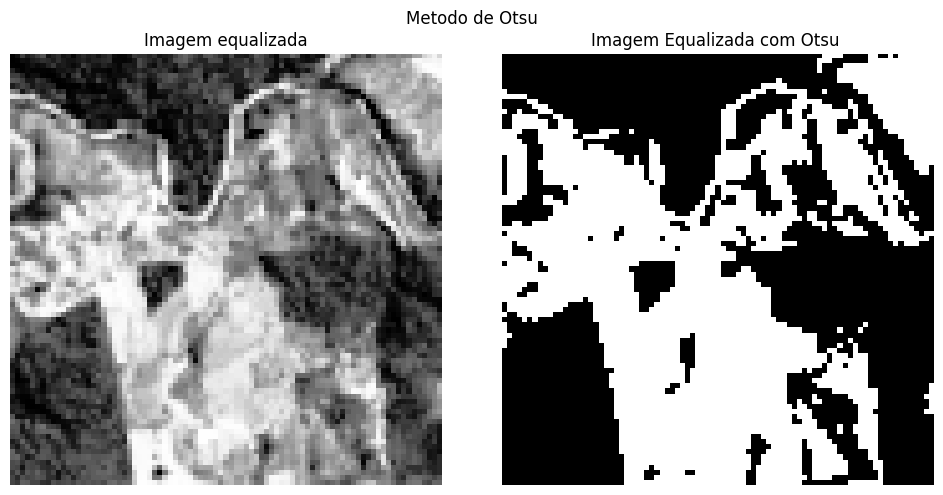

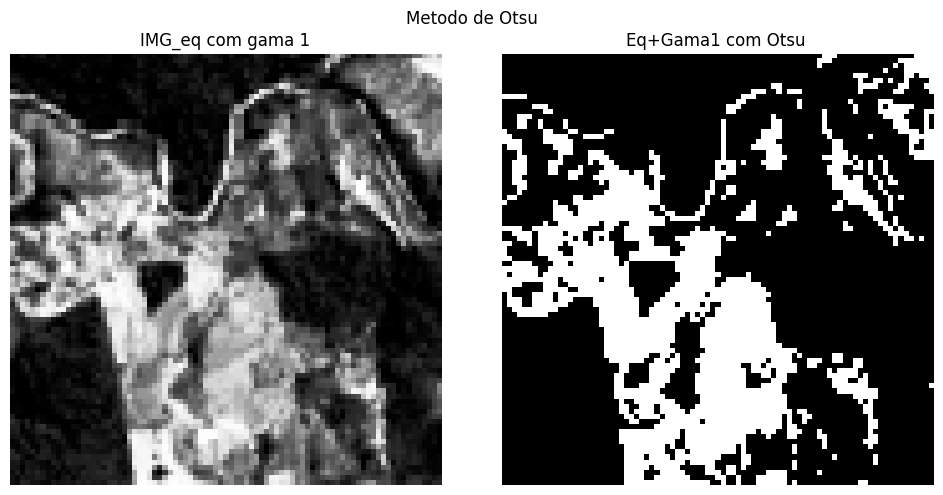

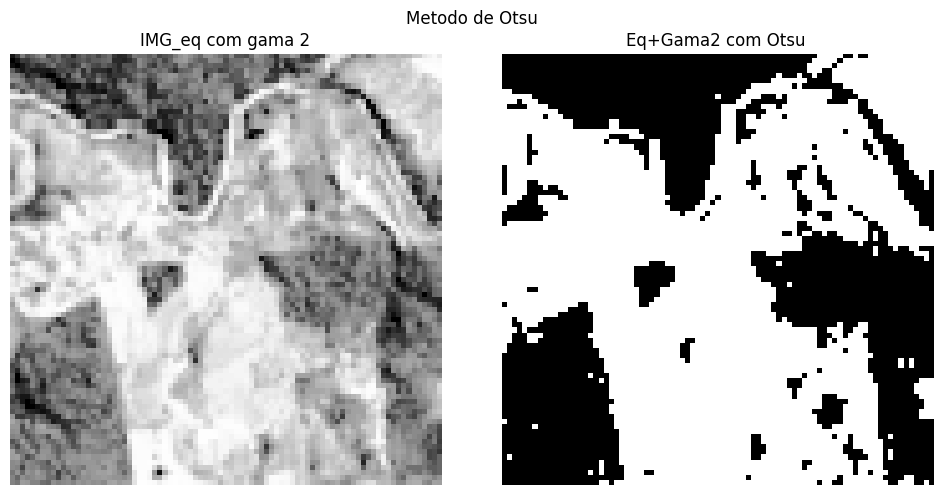

In [375]:
plot_2img("Metodo de Otsu", img_eq[0], "Imagem equalizada", img_bin4, "Imagem Equalizada com Otsu ")
plot_2img("Metodo de Otsu", img_eq_gama1, "IMG_eq com gama 1", img_bin5, "Eq+Gama1 com Otsu ")
plot_2img("Metodo de Otsu", img_eq_gama2, "IMG_eq com gama 2", img_bin6, "Eq+Gama2 com Otsu ")

##### Aplicando Otsu em uma Imagem Suavizada com o Filtro de Minimos Quadrados

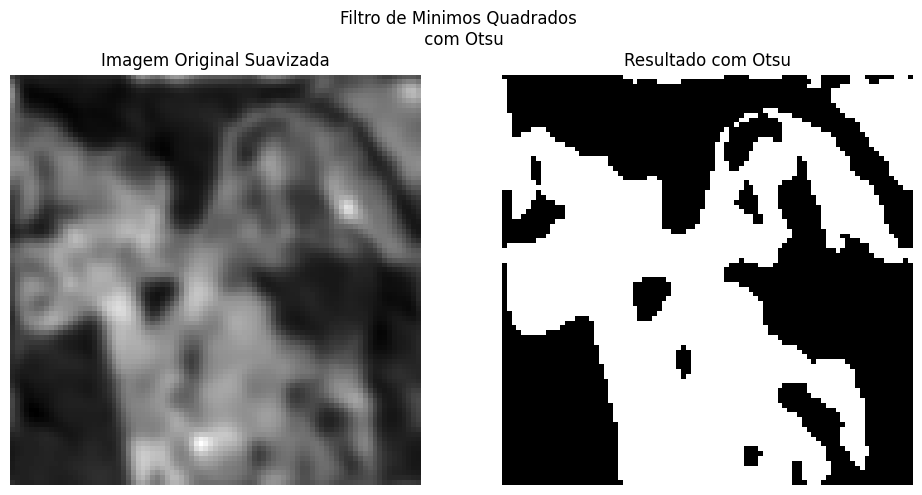

In [376]:
thresh_original = metodo_otsu(img_filt)
img_otsu_gam1 =  (img_filt > thresh_original).astype(np.uint8) * 255
plot_2img("Filtro de Minimos Quadrados \n com Otsu", img_filt, "Imagem Original Suavizada", img_otsu_gam1, "Resultado com Otsu")

Otsu's optimal threshold: 56
Otsu's optimal threshold: 134


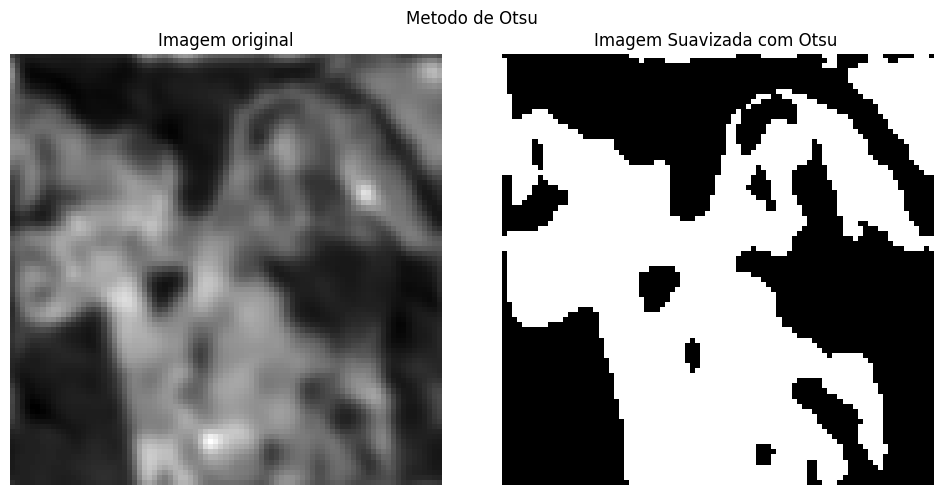

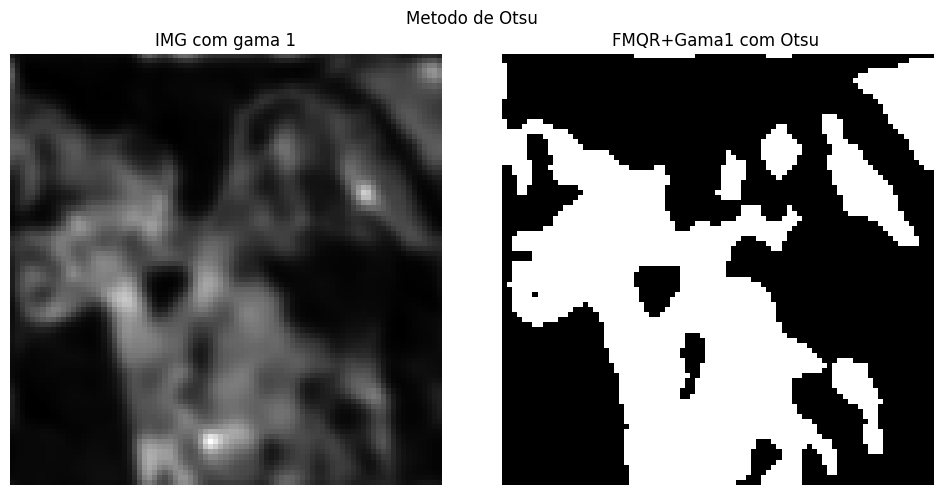

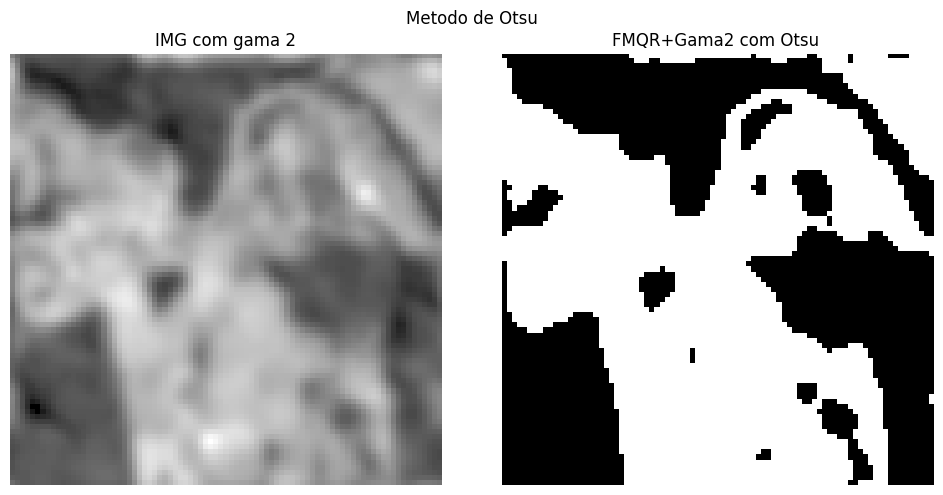

In [377]:
#Aplicando Otsu em imagens filtrada com correções gama
gama1, gama2 = 0.6, 2.0
img_filt_gama1 = correc_gamma(img_filt, gama1)
img_filt_gama2 = correc_gamma(img_filt, gama2)


otsu_gama1 = metodo_otsu(img_filt_gama1)
img_otsu_gam2 =  (img_filt_gama1 > otsu_gama1).astype(np.uint8) * 255
print(f"Otsu's optimal threshold: {otsu_gama1}") 

otsu_gama2 = metodo_otsu(img_filt_gama2)
img_otsu_gam3 =  (img_filt_gama2 > otsu_gama2).astype(np.uint8) * 255
print(f"Otsu's optimal threshold: {otsu_gama2}")

plot_2img("Metodo de Otsu", img_filt, "Imagem original", img_otsu_gam1, "Imagem Suavizada com Otsu ")
plot_2img("Metodo de Otsu", img_filt_gama1, "IMG com gama 1", img_otsu_gam2, "FMQR+Gama1 com Otsu ")
plot_2img("Metodo de Otsu", img_filt_gama2, "IMG com gama 2", img_otsu_gam3, "FMQR+Gama2 com Otsu ")


#### Segmentação com Metodo de Yen

Utilizando a biblioteca skimage

In [378]:
from skimage import filters

In [379]:
def metodo_Yen(img):
    #calcula o limiar de yen
    limiar_yen =  filters.threshold_yen(img)
    print(f"Limiar de Yen: {limiar_yen}")
    #retorna uma imagem binaria
    img_bin = img > limiar_yen

    return img_bin

Limiar de Yen: 68.11414378729091
Limiar de Yen: 82
Limiar de Yen: 147


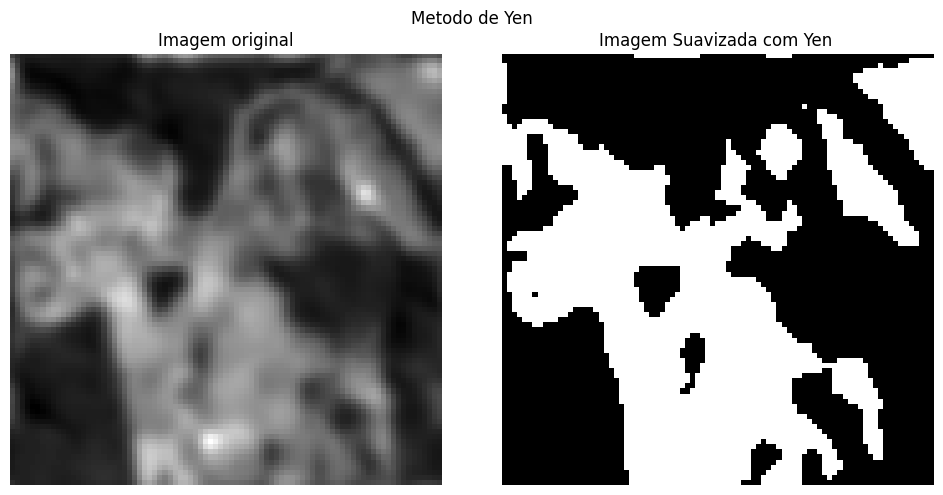

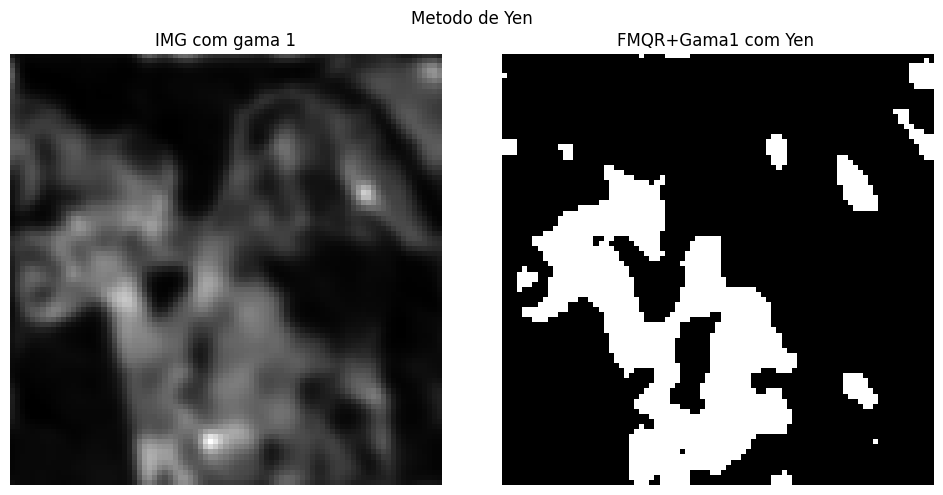

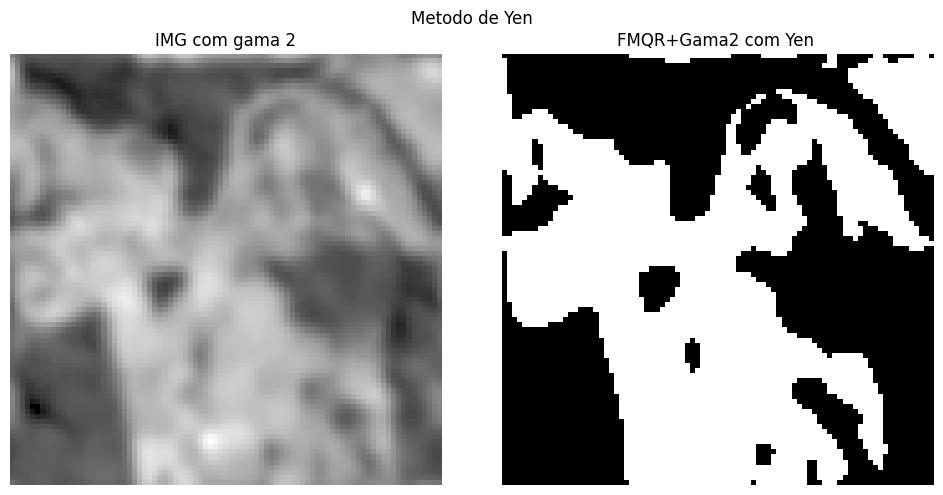

In [380]:
#Aplicando Yen em imagens filtrada com correções gama
img_yen1 = metodo_Yen(img_filt)
img_yen2 = metodo_Yen(img_filt_gama1)
img_yen3 = metodo_Yen(img_filt_gama2)

plot_2img("Metodo de Yen", img_filt, "Imagem original", img_yen1, "Imagem Suavizada com Yen ")
plot_2img("Metodo de Yen", img_filt_gama1, "IMG com gama 1", img_yen2, "FMQR+Gama1 com Yen ")
plot_2img("Metodo de Yen", img_filt_gama2, "IMG com gama 2", img_yen3, "FMQR+Gama2 com Yen ")


#### Aplicando Morfologia Matematica

In [ ]:
from skimage import morphology as morph

In [382]:
def open_close(img, selem):
    #criando um objt morfologico -> um quadrado cuja dist = 4
    

    #realizando o processo de abertura ( erosão + dilatação)
    img_opened = morph.binary_opening(img,selem)

    #realizando o processo de fechamentro (dilatação + erosão)
    img_result = morph.closing(img_opened, selem)

    #retorna uma nova img
    return img_result

/tmp/ipykernel_6941/3347755168.py:1: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = morph.square(4)


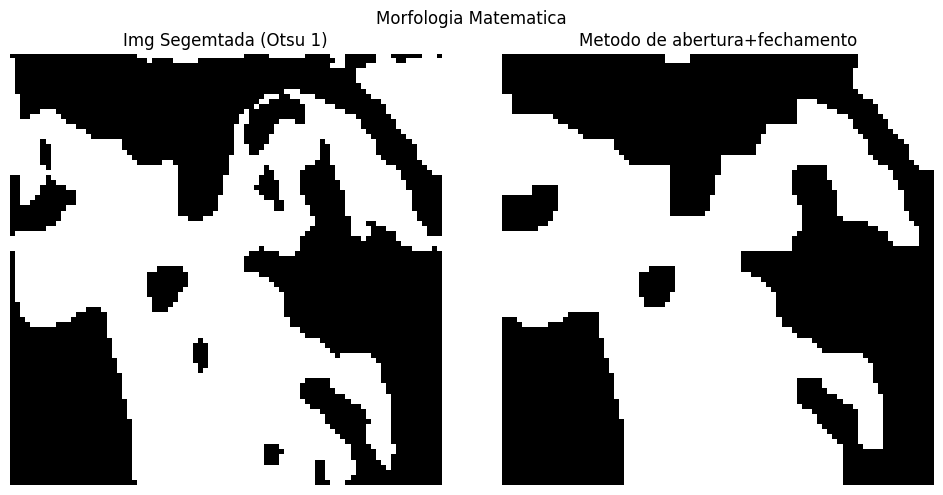

In [383]:
selem = morph.square(4)
plot_2img("Morfologia Matematica", img_otsu_gam1, "Img Segemtada (Otsu 1)", open_close(img_otsu_gam1, selem), "Metodo de abertura+fechamento")

/tmp/ipykernel_6941/927697701.py:1: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = morph.square(3)


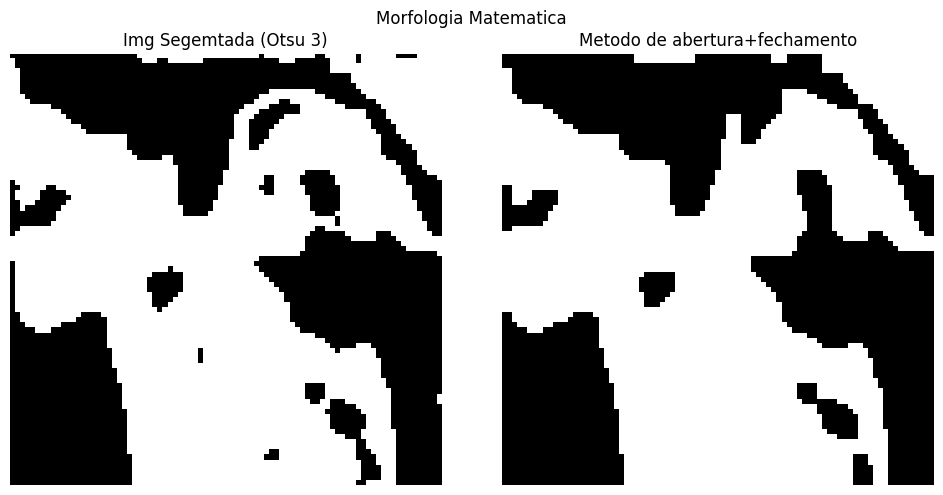

In [384]:
selem = morph.square(3)
plot_2img("Morfologia Matematica", img_otsu_gam3, "Img Segemtada (Otsu 3)", open_close(img_otsu_gam3, selem), "Metodo de abertura+fechamento")

/tmp/ipykernel_6941/3176125643.py:1: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = morph.square(4)


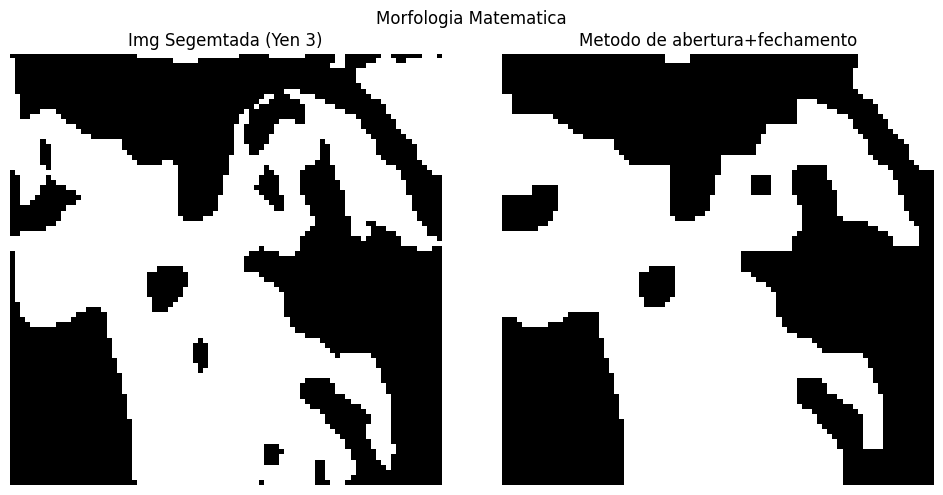

In [400]:
selem = morph.square(4)
plot_2img("Morfologia Matematica", img_yen3, "Img Segemtada (Yen 3)", open_close(img_yen3, selem), "Metodo de abertura+fechamento")

### Closing the Datasets
The ImageSegmentationDataset class holds open file handles to NetCDF files which need to be manually closed.

In [385]:
dataset.close()
dataset_merged_bands.close()

### Incorporation into Training and Evaluation
This dataset can be wrapped in a straightforward manner for use in a desired ML training / evaluation framework, allowing for selection of desired data from within the returned dictionary, applying data transforms such as image resizing, and converting to framework compatible types.